In [30]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import numpy as np
import pandas as pd
import copy
from pprint import pprint
import matplotlib.pyplot as plt
from model_seq2seq import seq2seq
FILE_FOLDER = '../prediction_data/%s'
AFTER_FILE_FOLDER = '../prediction_data/afterAnalysis/%s'

# Train by past 3 months

In [2]:
train_data = pd.read_csv(AFTER_FILE_FOLDER % 'aq18_02_04.csv')
train_data[['PM25', 'PM10','O3']] = train_data[['PM25', 'PM10','O3']].\
                                     fillna(train_data[['PM25', 'PM10','O3']].mean())
train_data = train_data[['station_id', 'time', 'PM25', 'PM10', 'O3']]
train_data['PM25'] = train_data['PM25'].astype('int64')
train_data['PM10'] = train_data['PM10'].astype('int64')
train_data['O3'] = train_data['O3'].astype('int64')

In [3]:
# train_data.set_index
aq_stations_list = train_data['station_id'].unique().tolist()
len(aq_stations_list)
train_data_copy = train_data.copy()
train_data_copy.set_index(['station_id'],inplace=True)
train_data_copy.head()

,time,PM25,PM10,O3
station_id,,,,
aotizhongxin_aq,2018-01-31 16:00:00,49,82,6
aotizhongxin_aq,2018-01-31 17:00:00,47,80,5
aotizhongxin_aq,2018-01-31 18:00:00,46,91,5
aotizhongxin_aq,2018-01-31 19:00:00,60,95,6
aotizhongxin_aq,2018-01-31 20:00:00,52,91,5


In [28]:
def np_sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1 * x))
    
def generate_training_data(station_name,pollution_name):
    current_train_set = []
    batch = 10
    df_part = train_data_copy.loc[station_name]
    data_array = np.array(df_part[pollution_name])
    len_array = len(data_array)
    # 120 + 48
    X = np.array([])
    y = np.array([])
    normalization = {'PM25': train_data['PM25'].max(),
                     'PM10': train_data['PM10'].max(),
                     'O3': train_data['O3'].max()}
    iterate = 0
    for begin_date_i in range(0,len_array - 168):
        iterate += 1
        X = np.append(X, data_array[begin_date_i: begin_date_i + 120])
        y = np.append(y, data_array[begin_date_i + 120: begin_date_i + 168])
        if(iterate % batch == 0):
            current_train_set.append(
                (X/normalization[pollution_name],y/normalization[pollution_name])
            )
            X = np.array([])
            y = np.array([])
#             break
    return current_train_set
current_train_set = generate_training_data('aotizhongxin_aq','PM25')
len(current_train_set)

191

In [27]:
def train_model():
    X, y, predict, global_step = seq2seq()
    with tf.variable_scope('loss'):
        output_loss = 0
        for _y, _Y in zip(predict, y):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        l2loss = 0
        for v in tf.trainable_variables():
            if 'Biases_' in v.name or 'Weights_' in v.name:
                l2loss += tf.reduce_mean(tf.nn.l2_loss(v))

        loss = output_loss + 0.003 * l2loss
        # parameter lambda l2 regulaization
    with tf.variable_scope('optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(loss=loss, learning_rate=0.00001,
                global_step=global_step, optimizer='Adam', clip_gradients=2.5)
        # parameter learning_rate clip_gradients
    pollutions = ['PM25', 'PM10', 'O3']
    for aq_station in aq_stations_list:
        for pollution_name in pollutions:
            print(aq_station, pollution_name)
            with tf.Session() as session:
                session.run(tf.global_variables_initializer())
                d = current_train_set
                n = 0
                for batch_set in current_train_set:
                    n += 1
                    x_, y_ = batch_set
                    feed = {X[t]:x_.reshape((-1, 120))[:,t].reshape((-1, 1)) for t in range(120)}
                    feed.update({y[t]: y_.reshape((-1, 48))[:,t].reshape((-1, 1)) for t in range(48)})
                    _, l = session.run([optimizer, loss], feed_dict=feed)
                    
                print("loss after %d iteractions : %.3f" %(n ,l))
                saver = tf.train.Saver()
                save_path = saver.save(session, AFTER_FILE_FOLDER%('NNdata/iteraction_%s_%s' % (aq_station[:-3], pollution_name)))
                print("Checkpoint saved at: ", save_path)

-------------------------------------------
aotizhongxin_aq PM25
loss after 63 iteractions : 0.203
Checkpoint saved at:  ../prediction_data/afterAnalysis/NNdata/iteraction_aotizhongxin_PM25


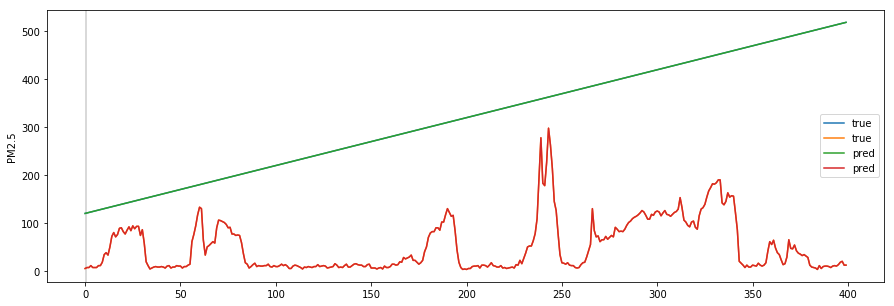

In [48]:
warmup_steps = 1
signal_pred = tt

# Get the true output-signal from the data-set.
signal_true = tt

# Make the plotting-canvas bigger.
plt.figure(figsize=(15,5))

# Plot and compare the two signals.
plt.plot(signal_true, label='true')
plt.plot(signal_pred, label='pred')

# Plot grey box for warmup-period.
p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

# Plot labels etc.
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [50]:
train_data_copy.loc['aotizhongxin_aq']
tt = train_data_copy.loc['aotizhongxin_aq']
tt = tt.reset_index()
tt = tt.loc[120:519]
tt = tt[['PM25']]
tt.reset_index(inplace=True)
tt = tt[['PM25']]

In [51]:
tt

,PM25
0,5
1,7
2,7
3,11
4,7
5,7
6,7
7,11
8,11
9,18
